<a href="https://colab.research.google.com/github/Vardhan77/DeepLearningWithEVA/blob/master/GRADCAM_SESSION10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libraries and modules**

In [1]:
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Add, BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils

from keras.datasets import mnist
from matplotlib import pyplot as plt
%matplotlib inline

Using TensorFlow backend.



# GRADCAM FOR LAST LAYER


Let's start with a pretrained VGG model

In [0]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import numpy as np
import cv2

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


1.  Loading helper functions
2.  Load VGG
3. Load Image
4. Rescale image to 224x224x3 (VGG's expectation, why?)
5. Use expand_dims to convert image to a batch of size 1
6. Preprocesing normalizes our input image by subtracting mean RGB values

In [4]:
model = VGG16(weights="imagenet")
from skimage import io
from urllib.request import urlopen
#dog = urlopen("https://media.karousell.com/media/photos/products/2018/08/20/16_scale_tony_stark_avenger3_headscrupt_with_glasses_1534759826_e79b0cf4_progressive.jpg")
dog = io.imread("/content/drive/My Drive/TinyImageNet200/tony.jpg")
dog = cv2.resize(dog, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
x = image.img_to_array(dog)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

W0821 05:59:12.791580 140597093005184 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0821 05:59:12.835371 140597093005184 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0821 05:59:12.842464 140597093005184 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0821 05:59:12.882266 140597093005184 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



553467904/553467096 [==============================] - 6s 0us/step


W0821 05:59:19.742787 140597093005184 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0821 05:59:19.743971 140597093005184 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



1. We get the predictions for the image
2. We take the topmost class index
3. Take output from the final convolutional layer

In [5]:
preds = model.predict(x)
class_idx = np.argmax(preds[0])
print(class_idx)
class_output = model.output[:, class_idx]
last_conv_layer = model.get_layer("block5_conv3")

837


In [0]:
from keras import backend as K

1. Compute the gradient of the class output value with respect to the feature map
2. Pool the gradients over all the axies leaving out the channel dimension
3. Weigh the output feature map with the computed gradient values

In [7]:
grads = K.gradients(class_output, last_conv_layer.output)[0]
print(grads.shape)
pooled_grads = K.mean(grads, axis=(0, 1, 2))
print(pooled_grads.shape)
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(512):
  conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

(?, 14, 14, 512)
(512,)


1. Average the weighted feature map along the channel dimension resulting in a heat map of size 14x14 
2. Normalize the heat map to make the values between 0 and 1

In [8]:
heatmap = np.mean(conv_layer_output_value, axis = -1)
print(conv_layer_output_value.shape)
print(heatmap.shape)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

(14, 14, 512)
(14, 14)


Show the results

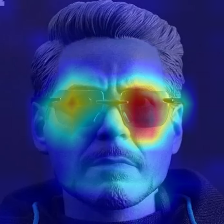

In [9]:
heatmap = cv2.resize(heatmap, (dog.shape[1], dog.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(dog, 0.5, heatmap, 0.5, 0)
from google.colab.patches import cv2_imshow
cv2_imshow( dog)
cv2_imshow(superimposed_img)

In [10]:
!pip install keract

40960/35363 [==================================] - 0s 0us/step


W0821 05:59:37.997887 140597093005184 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



sunglasses (17.55520850419998)
input_2:0 (224, 224, 3) -> Skipped. First dimension is not 1.
block1_conv1_1/Relu:0 (1, 224, 224, 64) 


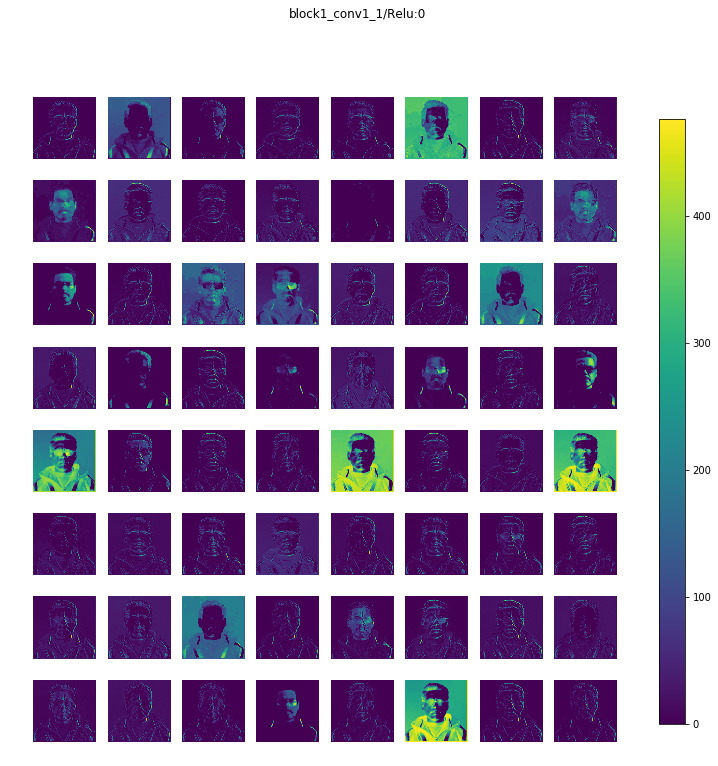

block1_conv2_1/Relu:0 (1, 224, 224, 64) 


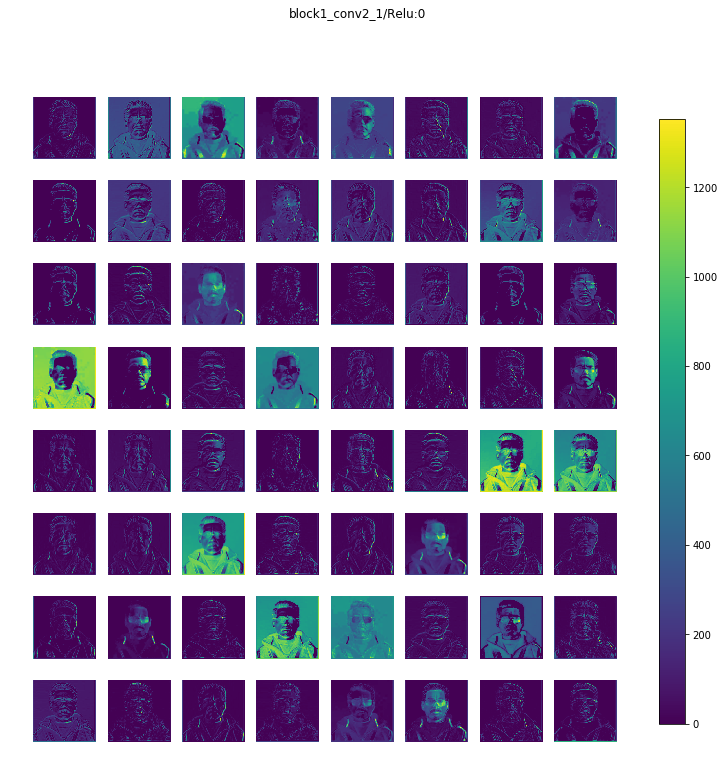

block1_pool_1/MaxPool:0 (1, 112, 112, 64) 


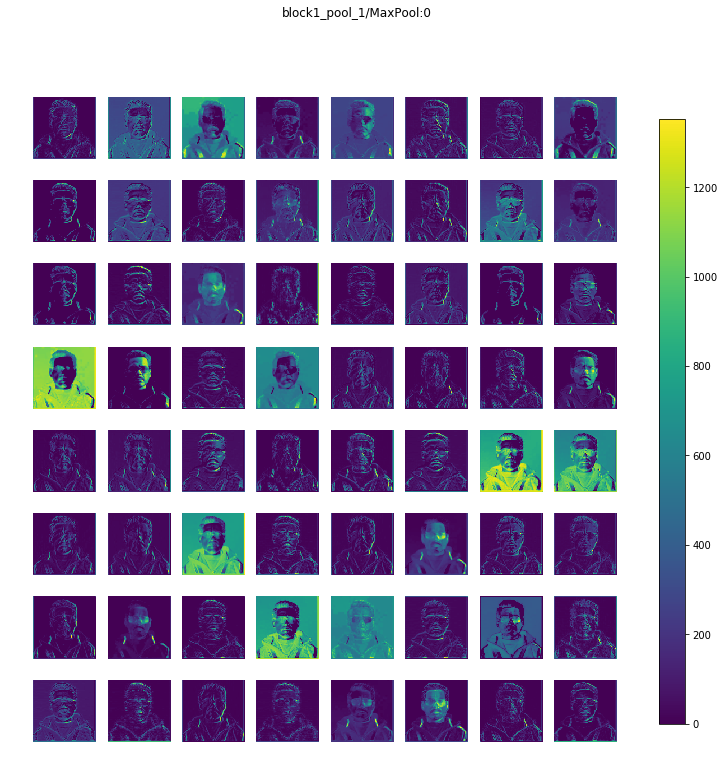

block2_conv1_1/Relu:0 (1, 112, 112, 128) 


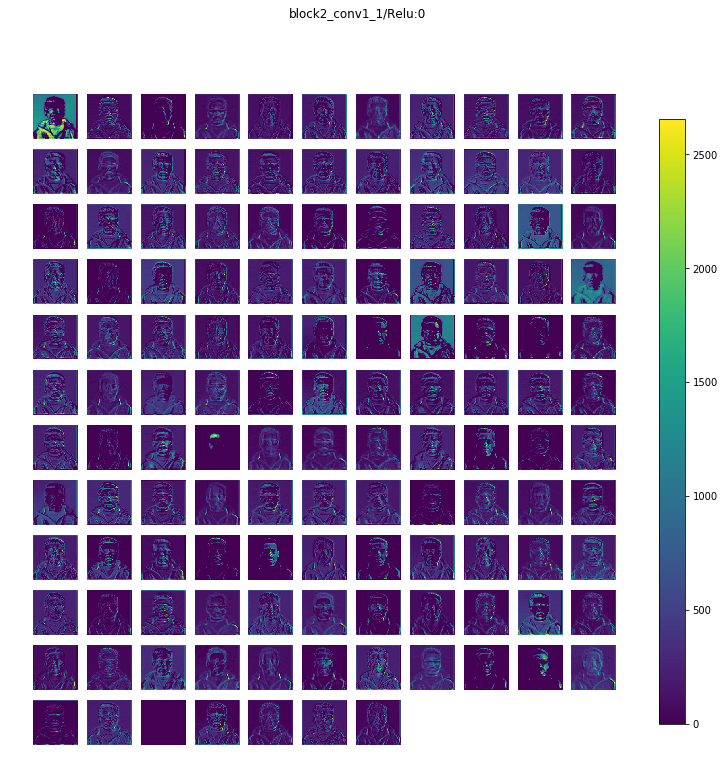

block2_conv2_1/Relu:0 (1, 112, 112, 128) 


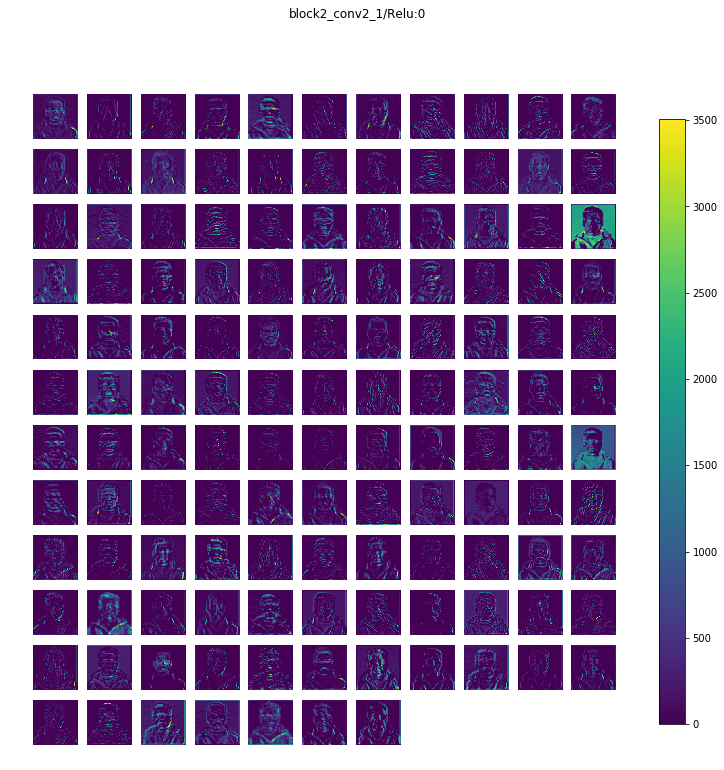

block2_pool_1/MaxPool:0 (1, 56, 56, 128) 


block3_conv1_1/Relu:0 (1, 56, 56, 256) 


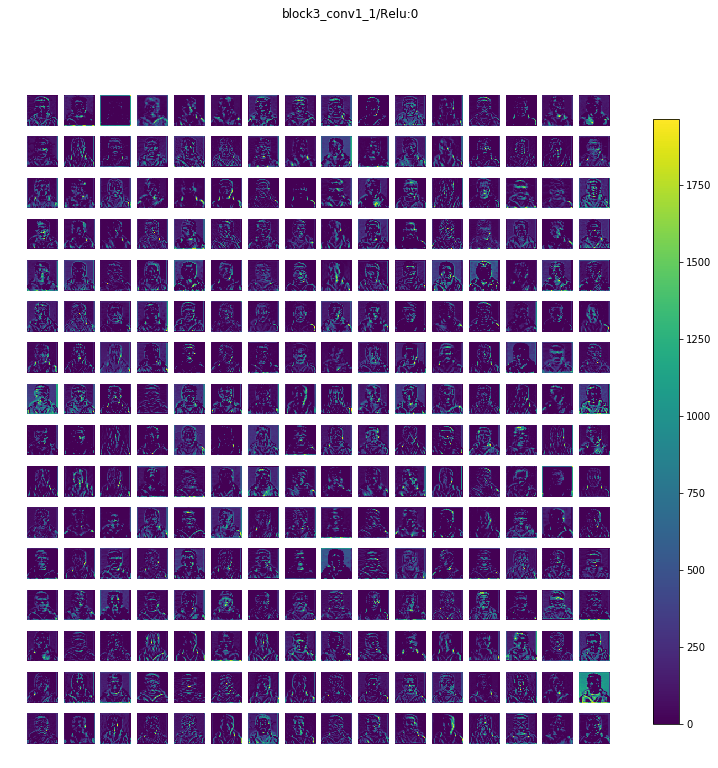

block3_conv2_1/Relu:0 (1, 56, 56, 256) 


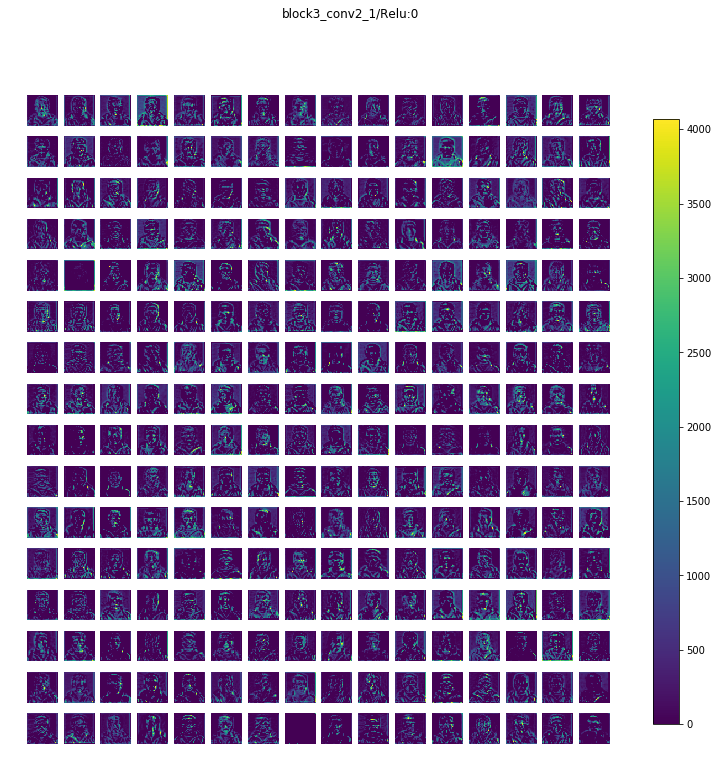

block3_conv3_1/Relu:0 (1, 56, 56, 256) 


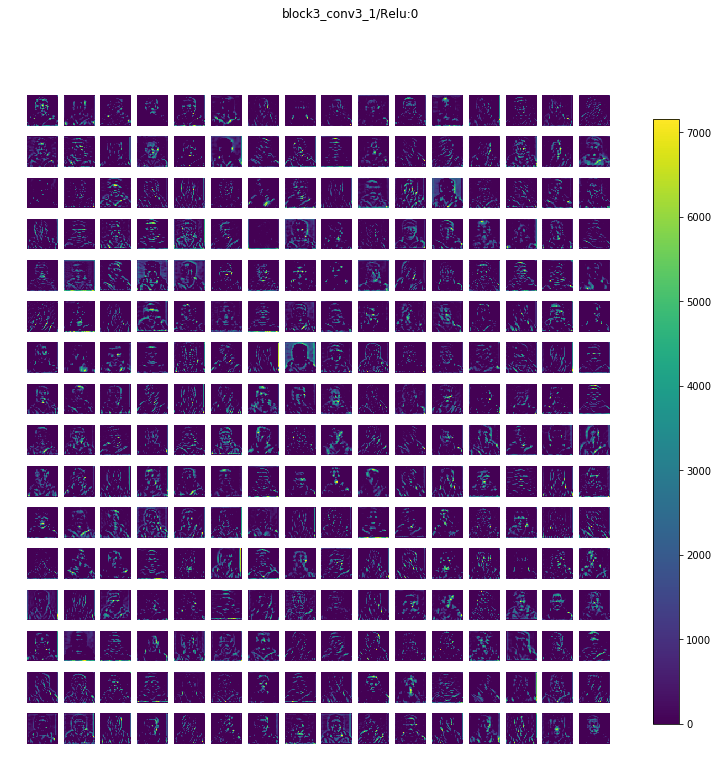

block3_pool_1/MaxPool:0 (1, 28, 28, 256) 


block4_conv1_1/Relu:0 (1, 28, 28, 512) 


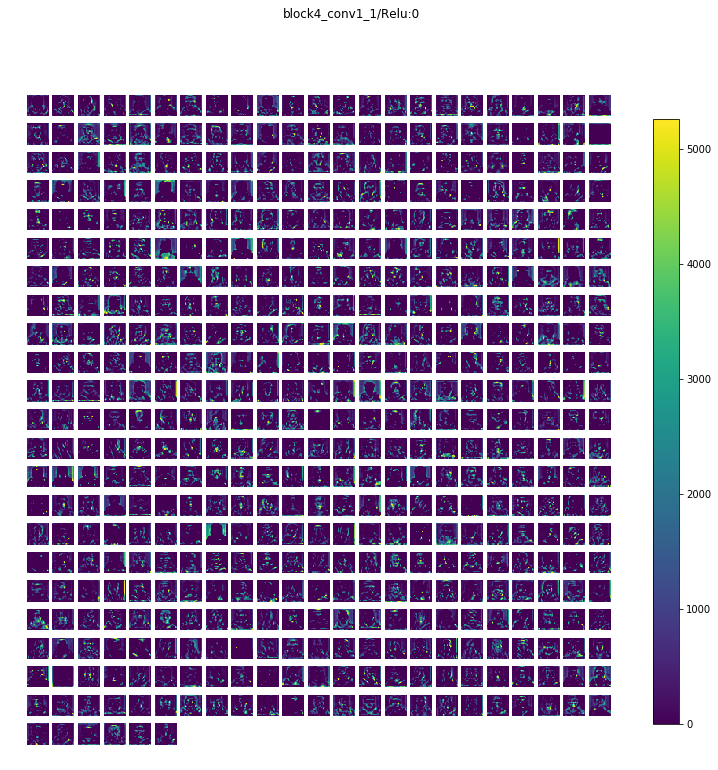

block4_conv2_1/Relu:0 (1, 28, 28, 512) 


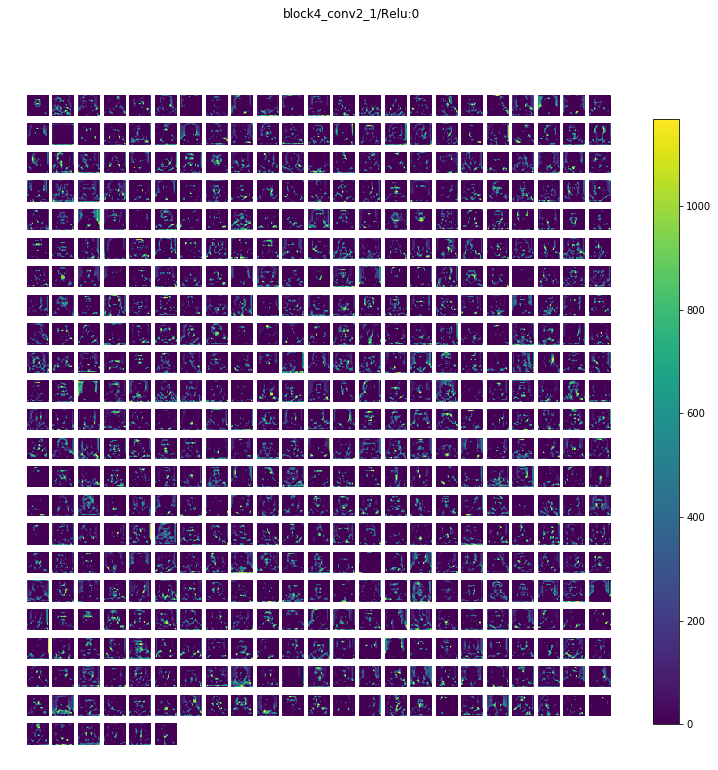

block4_conv3_1/Relu:0 (1, 28, 28, 512) 


block4_pool_1/MaxPool:0 (1, 14, 14, 512) 


block5_conv1_1/Relu:0 (1, 14, 14, 512) 


block5_conv2_1/Relu:0 (1, 14, 14, 512) 


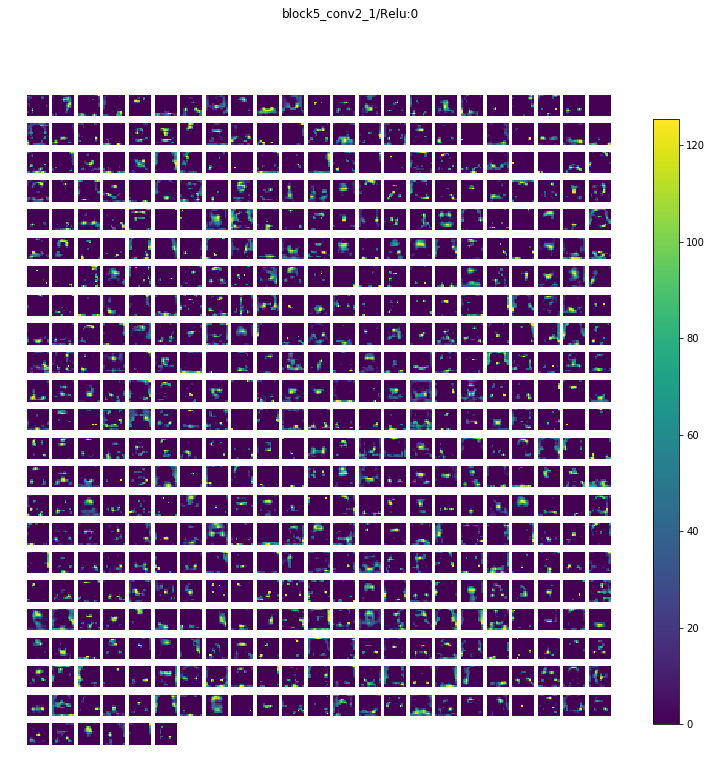

block5_conv3_1/Relu:0 (1, 14, 14, 512) 


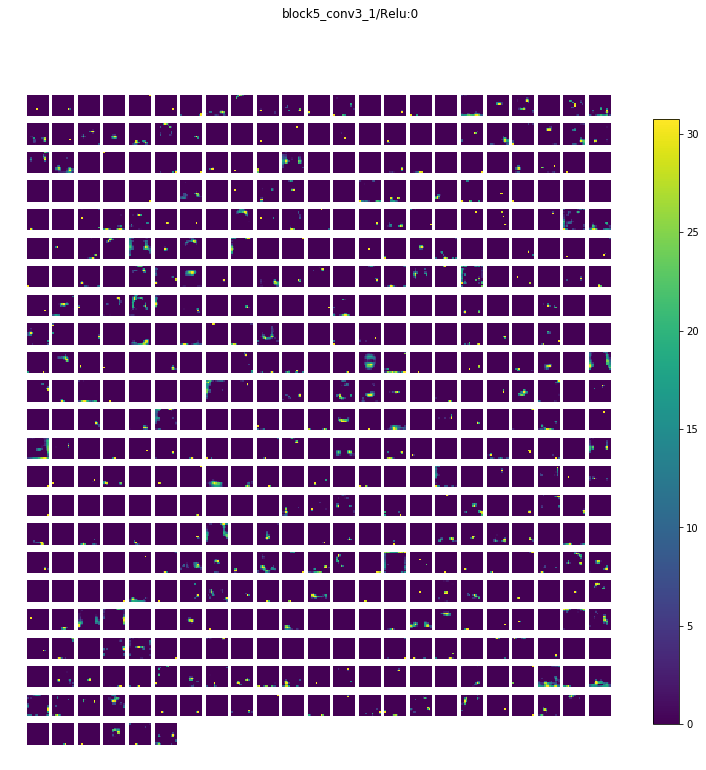

block5_pool_1/MaxPool:0 (1, 7, 7, 512) 


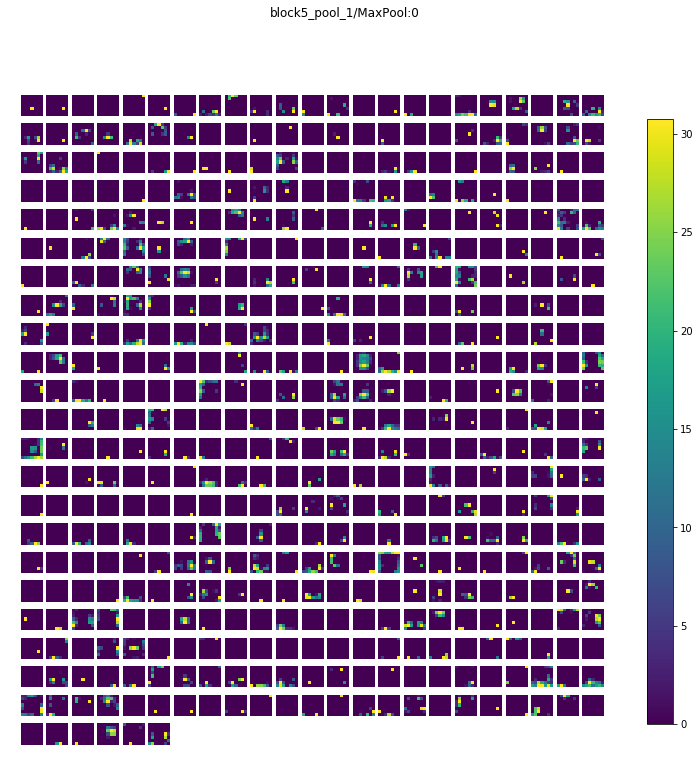

flatten_1/Reshape:0 (1, 25088) -> Skipped. 2D Activations.
fc1_1/Relu:0 (1, 4096) -> Skipped. 2D Activations.
fc2_1/Relu:0 (1, 4096) -> Skipped. 2D Activations.
predictions_1/Softmax:0 (1, 1000) -> Skipped. 2D Activations.


In [11]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import img_to_array

model = VGG16()

from PIL import Image
import requests
from io import BytesIO

url = 'https://ae01.alicdn.com/kf/HTB1wnD8bcrrK1RjSspaq6AREXXaR/MK100-Tony-Stark-Doll-Model-Head-Carved-Glasses-Seamless-Flexible-Body-Model-1-6-Action-Figure.jpg_220x220q90.jpg'
response = requests.get(url)
image = Image.open(BytesIO(response.content))
image = image.crop((0, 0, 224, 224))
image = img_to_array(image)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
image = preprocess_input(image)
yhat = model.predict(image)
label = decode_predictions(yhat)
label = label[0][0]
print('{} ({})'.format(label[1], label[2] * 100))

import keract

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
activations = keract.get_activations(model, image)
first = activations.get('block1_conv1/Relu:0')
keract.display_activations(activations)

#GRADCAM BLOCK5_CONV2 (LAYER (N-1))

In [12]:
preds = model.predict(x)
class_idx = np.argmax(preds[0])
print(class_idx)
class_output = model.output[:, class_idx]
last_conv_layer = model.get_layer("block5_conv2")

837


In [13]:
grads = K.gradients(class_output, last_conv_layer.output)[0]
print(grads.shape)
pooled_grads = K.mean(grads, axis=(0, 1, 2))
print(pooled_grads.shape)
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(512):
  conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

(?, 14, 14, 512)
(512,)


In [14]:
heatmap = np.mean(conv_layer_output_value, axis = -1)
print(conv_layer_output_value.shape)
print(heatmap.shape)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

(14, 14, 512)
(14, 14)


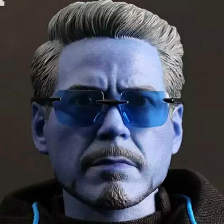

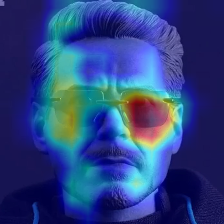

In [15]:
heatmap = cv2.resize(heatmap, (dog.shape[1], dog.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(dog, 0.5, heatmap, 0.5, 0)
from google.colab.patches import cv2_imshow
cv2_imshow( dog)
cv2_imshow(superimposed_img)

#GRADCAM BLOCK5_CONV1 (LAYER (N-2))

In [17]:
preds = model.predict(x)
class_idx = np.argmax(preds[0])
print(class_idx)
class_output = model.output[:, class_idx]
last_conv_layer = model.get_layer("block5_conv1")

837


In [18]:
grads = K.gradients(class_output, last_conv_layer.output)[0]
print(grads.shape)
pooled_grads = K.mean(grads, axis=(0, 1, 2))
print(pooled_grads.shape)
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(512):
  conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

(?, 14, 14, 512)
(512,)


In [19]:
heatmap = np.mean(conv_layer_output_value, axis = -1)
print(conv_layer_output_value.shape)
print(heatmap.shape)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

(14, 14, 512)
(14, 14)


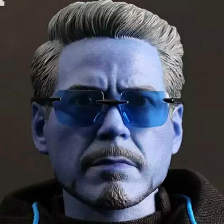

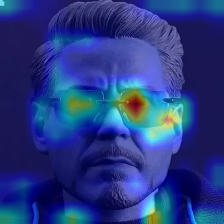

In [20]:
heatmap = cv2.resize(heatmap, (dog.shape[1], dog.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(dog, 0.5, heatmap, 0.5, 0)
from google.colab.patches import cv2_imshow
cv2_imshow( dog)
cv2_imshow(superimposed_img)